# Initial QPE Circuit Bayesian version.

In [8]:
# Importing libraries.
from pytket.circuit import Circuit
from pytket.circuit import CircBox
from pytket.circuit import QControlBox
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import qiskit_to_tk

In [2]:
from math import log2
from pytket.passes import DecomposeBoxes
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
import phayes

In [3]:
#from pytket.extensions.nexus import NexusBackend, QuantinuumConfig, Nexus
from datetime import datetime
from pytket.extensions.qiskit import AerBackend

In [4]:
from update_params import update_params

In [5]:
backend = AerBackend()

In [3]:
class bayesian_qpe_builder():
    
    def __init__(self, in_qubits, m_qubits, input_angle=1, z_angle=0, m=0, M=1):
        # Initializing the circuit.
        self.bayesian_qpe_circ: Circuit = Circuit()

        # Variables.
        self.m = m
        self.M = M
        self.use_M = True if M is not None else False
        if not self.use_M:
            self.M = 2**m
        self.in_qubits = in_qubits
        self.m_qubits = m_qubits
        self.input_angle = input_angle
        self.z_angle = z_angle
        
        # Creating the initial qubits.
        initial_state = Circuit(in_qubits).X(0)  # Initial state of the circuit (|psi>).

        # Creating the unitary gate.
        unitary_control = Circuit(m_qubits).U1(input_angle, 0)  # Unitary control gate.
        unitary_control.name = "U"
        controlled_u_gate = QControlBox(CircBox(unitary_control), 1)
        
        # Initiate the measurement qubit.
        measurement_register = self.bayesian_qpe_circ.add_q_register("|0>", m_qubits)
        # Initiate the initial state.
        state_prep_register = self.bayesian_qpe_circ.add_q_register("psi", in_qubits)

        # Adding tha Hadamard gate.
        for m_qubit in measurement_register:
            self.bayesian_qpe_circ.H(m_qubit)

        # Build the circuit.
        self.bayesian_qpe_circ.add_circuit(initial_state, list(state_prep_register))
        
        # Adding the U-Control gate.
        for m_qubit in range(m_qubits):
            control_index = m_qubits - m_qubit - 1 # Contrtoling the index of the qubit.
            control_qubit = [measurement_register[control_index]] # Controling WHICH qubit.
            for _ in range(self.M):
                self.bayesian_qpe_circ.add_qcontrolbox(
                    controlled_u_gate, control_qubit + list(state_prep_register)
                )

        # Adding the Rz and Hadamard.
        for m_qubit in measurement_register:
            self.bayesian_qpe_circ.Rz(z_angle, m_qubit)

        for m_qubit in measurement_register:
            self.bayesian_qpe_circ.H(m_qubit)

    def show_circuit(self):
        return render_circuit_jupyter(self.bayesian_qpe_circ)
            
        

In [4]:
bayesian_qpe = bayesian_qpe_builder(1, 1, input_angle=0.1, z_angle=0.5, m=0)

In [10]:
bqpe=qiskit_to_tk(bayesian_qpe.build_circuit())

AttributeError: 'bayesian_qpe_builder' object has no attribute 'build_circuit'

In [5]:
bayesian_qpe.show_circuit()

In [7]:
class iterative_phase_estimation():
    """
    A class to perform iterative phase estimation algorithm.
    
    This class estimates the phase of a quantum state using the iterative phase estimation algorithm. 
    The algorithm iteratively refines the estimate of the phase by adjusting the measurement basis 
    and interpreting the measurement outcomes.
    
    Attributes:
        M_0 (int): Initial value of M, controls the precision of the phase estimation.
        z_angle_0 (float): Initial z-axis rotation angle.
        precision (int): The number of bits of precision for the phase estimate.
        backend: The quantum computation backend to run circuits.
    """

    def __init__(self, M_0=None, z_angle_0=None, precision=3, backend=None):
        """
        Initializes the iterative phase estimation algorithm with optional parameters.
        
        Parameters:
            M_0 (int, optional): The starting value of M. Defaults to 2**(precision-1) if None.
            z_angle_0 (float, optional): The starting z-axis angle for rotation. Defaults to 0 if None.
            precision (int, optional): The desired precision for the phase estimate. Defaults to 3.
            backend: The backend to execute quantum circuits. Defaults to None.
        """
        self.M_0 = M_0 if M_0 is not None else 2**(precision-1)
        self.z_angle_0 = z_angle_0 if z_angle_0 is not None else 0.
        self.M_list = [self.M_0]  # Tracks the M values used in each iteration.
        self.angle_list = [self.z_angle_0]  # Tracks the angles used in each iteration.
        self.precision = precision
        self.phi_list = []  # Tracks the phi values obtained in each iteration.
        self.backend = backend

    def next_params(self, phi):
        """
        Calculates the next parameters (M and angle) for the iteration based on the latest phi value.
        
        Parameters:
            phi (int): The phi value obtained from the latest quantum measurement.
        
        Returns:
            tuple: A tuple containing the new M value and the new angle for the next iteration.
        """
        last_M, last_angle = self.M_list[-1], self.angle_list[-1]
        precision = self.precision
        n_updates = len(self.M_list)

        new_M = 2**(precision - n_updates - 1)

        int_list = 2**(-np.arange(1, precision + 1, 1)[::-1].astype(float))
        new_angle = -np.pi * np.sum(int_list[:n_updates] * self.phi_list)

        self.M_list.append(new_M)
        self.angle_list.append(new_angle)

        return new_M, new_angle

    def next_phi(self, circuit):
        """
        Processes the given circuit to extract the next phi value.
        
        This method involves compiling the circuit for the backend, executing it, 
        and interpreting the result to obtain phi.
        
        Parameters:
            circuit: The quantum circuit to be processed.
        
        Returns:
            int: The new phi value extracted from the circuit execution result.
        """
        # Assuming DecomposeBoxes is a method or class available in the context for circuit processing.
        DecomposeBoxes().apply(circuit)
        compiled_circ = self.backend.get_compiled_circuit(circuit)
        n_shots = 1024  # The number of shots for the circuit execution.
        result = self.backend.run_circuit(compiled_circ, n_shots)
        #print(result.get_counts().items())
        for key, val in result.get_counts().items():
            meas = key[1]
            if meas==0:
                P_0 = val/n_shots
                P_1 = 1-P_0
            elif meas==1:
                P_1 = val/n_shots
                P_0 = 1-P_1
        #print(P_0, P_1)
        new_phi = 0 if P_0 > P_1 else 1

        #new_phi = list(result.get_counts())[0][1]  # Assuming specific format for result interpretation.

        self.phi_list.append(new_phi)
        return new_phi

    def get_final_estimate(self):
        """
        Calculates the final phase estimate after all iterations.
        
        Returns:
            float: The final estimate of the phase.
        """
        precision = self.precision
        n_updates = len(self.M_list)
        int_list = 2**(-np.arange(0, precision, 1)[::-1].astype(float))
        final_angle = np.pi * np.sum(int_list[:n_updates] * self.phi_list)
        self.final_angle = final_angle
        return final_angle


In [26]:
phase_est_project = Nexus().new_project(f"Phase Estimation Tutorial - {datetime.now()}")

configuration = QuantinuumConfig(device_name="H1-1E")
#, user_group="iQuHACK_2024")

backend = NexusBackend(
    backend_config= configuration, 
    project= phase_est_project
)


New project created: Phase Estimation Tutorial - 2024-02-04 01:22:13.435093

Started using project with name: Phase Estimation Tutorial - 2024-02-04 01:22:13.435093


In [9]:
def get_estimate(input_angle, precision):
    IQPE = iterative_phase_estimation(precision=precision, backend=backend)
    for i in range(IQPE.precision):
        M, angle = IQPE.M_list[-1], IQPE.angle_list[-1]
        m = int(log2(M))
        #print(M, angle, m)
        circuit = bayesian_qpe_builder(1, 1, input_angle=input_angle, z_angle=angle, m=m).bayesian_qpe_circ.measure_all()
        phi = IQPE.next_phi(circuit)
        #print(IQPE.phi_list)
        if i < IQPE.precision - 1:
            IQPE.next_params(phi)
    return IQPE.get_final_estimate()

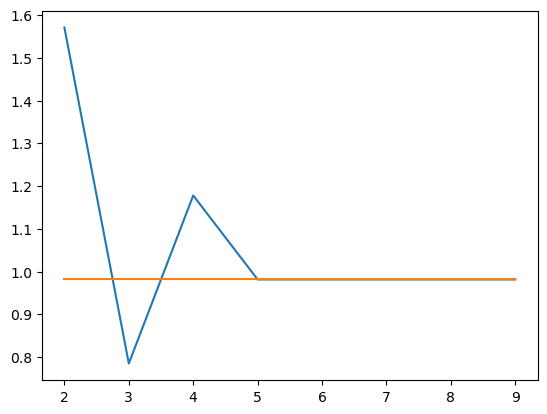

In [138]:
input_angle = 2**-2 + 2**-4
precisions = np.arange(2,10)
data = [get_estimate(input_angle, precision) for precision in precisions]
plt.plot(precisions, data)
plt.plot(precisions, input_angle*np.pi*(1+np.zeros_like(precisions)))
plt.show()

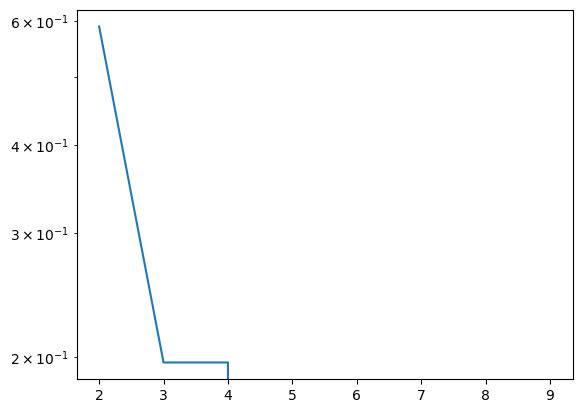

In [139]:
plt.plot(precisions, np.abs(data-input_angle*np.pi*(1+np.zeros_like(precisions))))
plt.yscale('log')
plt.show()

In [54]:
IQPE.get_final_estimate(), input_angle*np.pi

(4.558990901596125, 1.2566370614359172)

# Bayesian QPE

In [7]:
class alpha_phase_estimation():
    """
    A class to perform alpha phase estimation algorithm.
    
    This class estimates the phase of a quantum state using the iterative phase estimation algorithm. 
    The algorithm iteratively refines the estimate of the phase by adjusting the measurement basis 
    and interpreting the measurement outcomes.
    
    Attributes:
        M_0 (int): Initial value of M, controls the precision of the phase estimation.
        z_angle_0 (float): Initial z-axis rotation angle.
        precision (int): The number of bits of precision for the phase estimate.
        backend: The quantum computation backend to run circuits.
    """

    def __init__(self, s=100, M_max=1e100, backend=None):
        """
        Initializes the iterative phase estimation algorithm with optional parameters.
        
        Parameters:
            M_0 (int, optional): The starting value of M. Defaults to 2**(precision-1) if None.
            z_angle_0 (float, optional): The starting z-axis angle for rotation. Defaults to 0 if None.
            precision (int, optional): The desired precision for the phase estimate. Defaults to 3.
            backend: The backend to execute quantum circuits. Defaults to None.
        """
        self.phi_list = []  # Tracks the phi values obtained in each iteration.
        self.backend = backend
        self.phi_arr = np.linspace(-np.pi, np.pi, 1024)
        self.s = s
        self.posterior_state = phayes.init()
        self.errors = []
        self.M_max = M_max
            
    def normal_dist(self, mu, sigma):
        return np.exp(-0.5*((self.phi_arr - mu) / sigma)**2)

    # def params(self):
    #     mu, sigma = self.mu_list[-1], self.sigma_list[-1]
    #     M = max(1, int(1./sigma))
    #     angle = mu-sigma
    #     return M, angle

    def next_phi(self, circuit):
        """
        Processes the given circuit to extract the next phi value.
        
        This method involves compiling the circuit for the backend, executing it, 
        and interpreting the result to obtain phi.
        
        Parameters:
            circuit: The quantum circuit to be processed.
        
        Returns:
            int: The new phi value extracted from the circuit execution result.
        """
        # Assuming DecomposeBoxes is a method or class available in the context for circuit processing.
        DecomposeBoxes().apply(circuit)
        compiled_circ = self.backend.get_compiled_circuit(circuit)
        n_shots = self.s  # The number of shots for the circuit execution.
        result = self.backend.run_circuit(compiled_circ, n_shots)

        for i, (key, val) in enumerate(result.get_counts().items()):
            meas = key[1]
            meas_arr = np.zeros(self.s, dtype=int)
            meas_arr[:val] = meas
            meas_arr[val:] = 1-meas
            M, beta = phayes.get_k_and_beta(self.posterior_state)
            self.posterior_state = phayes.update(self.posterior_state, meas_arr, M, beta)
            if M > self.M_max:
                beta = phayes.get_beta_given_k(self.posterior_state, self.M_max)[0]
                self.posterior_state = phayes.update(self.posterior_state, meas_arr, self.M_max, beta)
            else:
                self.posterior_state = phayes.update(self.posterior_state, meas_arr, M, beta)
            if i>0:
                break
            
        # meas = int(list(measurement)[0])
        # val = list(measurement.values())[0]
        # meas_arr = np.zeros(self.s, dtype=int)
        # meas_arr[:val] = meas
        # meas_arr[val:] = 1-meas
        # #print(meas_arr)
        # M, beta = phayes.get_k_and_beta(self.posterior_state)
        # self.posterior_state = phayes.update(self.posterior_state, meas_arr, M, beta)

    def next_phi_qiskit(self, measurement):
        """
        Processes the given circuit to extract the next phi value.
        
        This method involves compiling the circuit for the backend, executing it, 
        and interpreting the result to obtain phi.
        
        Parameters:
            circuit: The quantum circuit to be processed.
        
        Returns:
            int: The new phi value extracted from the circuit execution result.
        """


        meas = int(list(measurement)[0])
        val = list(measurement.values())[0]
        meas_arr = np.zeros(self.s, dtype=int)
        meas_arr[:val] = meas
        meas_arr[val:] = 1-meas
        #print(meas_arr)
        M, beta = phayes.get_k_and_beta(self.posterior_state)
        if M > self.M_max:
            beta = phayes.get_beta_given_k(self.posterior_state, self.M_max)[0]
            self.posterior_state = phayes.update(self.posterior_state, meas_arr, self.M_max, beta)
        else:
            self.posterior_state = phayes.update(self.posterior_state, meas_arr, M, beta)

    def get_final_estimate(self):
        """
        Calculates the final phase estimate after all iterations.
        
        Returns:
            float: The final estimate of the phase.
        """
        
        final_angle = float(phayes.circular_mean(self.posterior_state)) * 2 / np.pi
        self.final_angle = final_angle
        return final_angle

    def get_final_error(self, val):
        """
        Calculates the final phase estimate after all iterations.
        
        Returns:
            float: The final estimate of the phase.
        """
        
        error = float(phayes.cosine_distance(val, self.posterior_state))
        self.errors.append(error)


In [8]:
from qiskit import QuantumCircuit, Aer, execute

In [9]:
# Function to apply controlled-U operations
def apply_cu(qc, ctrl_qubit, target_qubit, U, power):
    U_cp = U.copy()
    U_cp.name = f"U^{2**power}"
    qc.append(U_cp.control(), [ctrl_qubit, target_qubit])

def qiskit_circuit(input_angle, M, angle, shots=10):
    # Define the unitary operator U. Here we use a Z gate as an example.
    U = QuantumCircuit(1)
    U.rz(np.pi*input_angle*M, 0)
    U.name = "U"

    # Number of iterations / precision bits
    num_iterations = 1

    # Prepare the quantum circuit
    qc = QuantumCircuit(2, 1)  # 2 qubits, 1 classical bit for measurement

    # Initialize the eigenstate of U (assuming |1> is an eigenstate of U)
    qc.x(1)  # Prepare the state |1>

    for k in range(num_iterations):
        # Apply Hadamard to auxiliary qubit
        qc.h(0)
        
        # Apply controlled-U operations conditioned on previous outcomes
        for i in range(2**k):
            apply_cu(qc, 0, 1, U, k)

        qc.rz(angle, 0)
        
        # Apply the inverse QFT (Hadamard for single qubit)
        qc.h(0)
        
        # Measure
        qc.measure(0, 0)
        
        # Execute the circuit
        backend = Aer.get_backend('qasm_simulator')
        job = execute(qc, backend, shots=shots)
        result = job.result()
        measurement = result.get_counts()

        #print(qc.draw())

        return measurement

    # The estimated phase would be determined here based on the measurements


In [118]:
def get_estimate_alpha(input_angle, precision):
    AQPE = alpha_phase_estimation(mu=0.5, sigma=0.4, s=10, precision=precision, backend=backend)
    for i in range(4):
        M, beta = phayes.get_k_and_beta(AQPE.posterior_state)
        angle = beta
        #m = int(log2(M))
        print("M, angle:", M, angle)
        if i%1==0:
            plt.plot(AQPE.phi_arr, phayes.pdf(AQPE.phi_arr, AQPE.posterior_state), label=i)
        circuit = bayesian_qpe_builder(1, 1, input_angle=input_angle, z_angle=angle/np.pi, M=M).bayesian_qpe_circ.measure_all()
        AQPE.next_phi(circuit)
        #measurement = qiskit_circuit(input_angle=input_angle, M=int(M), angle=float(angle))
        #AQPE.next_phi_qiskit(measurement)
    plt.legend()
    plt.show()
    return AQPE.get_final_estimate()

M, angle: 1 1.5707964
M, angle: 2 1.5707964
M, angle: 6 2.9447577
M, angle: 16 1.202395


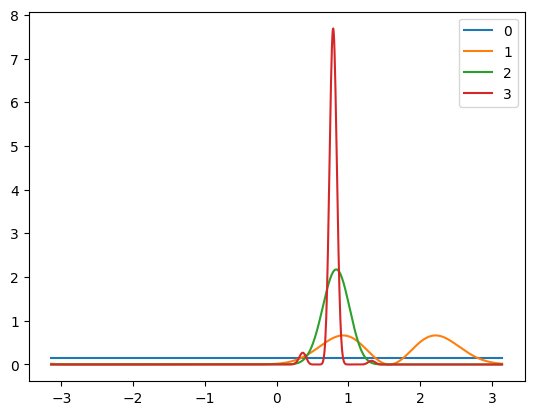

0.500386564675295

In [119]:
get_estimate_alpha(0.5, 10)

In [50]:
def get_estimate_bayesian(input_angle):
    final_angles = []
    s = 10
    AQPE = alpha_phase_estimation(s=s, M_max=1e10, backend=backend)
    for i in range(10):
        M, beta = phayes.get_k_and_beta(AQPE.posterior_state)
        if M > AQPE.M_max:
            M = AQPE.M_max
            beta = phayes.get_beta_given_k(AQPE.posterior_state, M)[0]

        angle = beta
        #m = int(log2(M))
        print("M, angle:", M, angle)
        plt.plot(AQPE.phi_arr, phayes.pdf(AQPE.phi_arr, AQPE.posterior_state), label=i)
        final_angles.append(AQPE.get_final_estimate())
        AQPE.get_final_error(input_angle  * np.pi / 2)
        #measurement = qiskit_circuit(input_angle=input_angle, M=int(M), angle=float(angle), shots=s)
        #AQPE.next_phi_qiskit(measurement)
        #circuit = bayesian_qpe_builder(1, 1, input_angle=input_angle, z_angle=angle/np.pi, M=M).bayesian_qpe_circ.measure_all()
        #AQPE.next_phi(circuit)
        measurement = qiskit_circuit_big_U(M=int(M), angle=float(angle), shots=s)
        AQPE.next_phi_qiskit(measurement)
    plt.legend()
    plt.show()
    errors = AQPE.errors
    return final_angles, errors

M, angle: 1 1.5707964
M, angle: 1 0.0
M, angle: 4 3.1015048
M, angle: 10 0.91135895
M, angle: 19 2.8869336
M, angle: 53 1.3742768
M, angle: 71 0.0
M, angle: 267 2.7078633
M, angle: 266 1.5707964
M, angle: 77 1.7584845


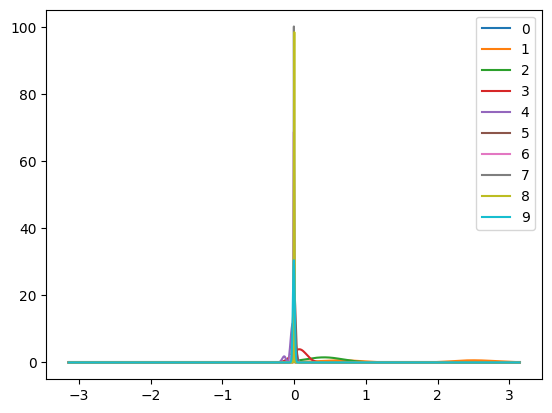

In [51]:
final_angles, errors = get_estimate_bayesian(0.0)

In [42]:
final_angles

[0.0,
 1.003315173977687,
 0.00010119656002609311,
 0.0325035895996213,
 -0.02092443630431562,
 -0.005807879420194361,
 0.007394247773172906,
 -0.0012431169590802079,
 -0.004720566665181222,
 -0.0003841633080342469]

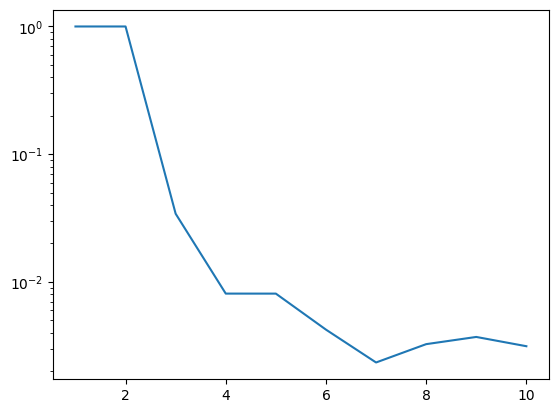

In [41]:
iters = np.arange(1, len(final_angles)+1)
plt.plot(iters, np.abs(errors))
plt.yscale('log')
plt.show()

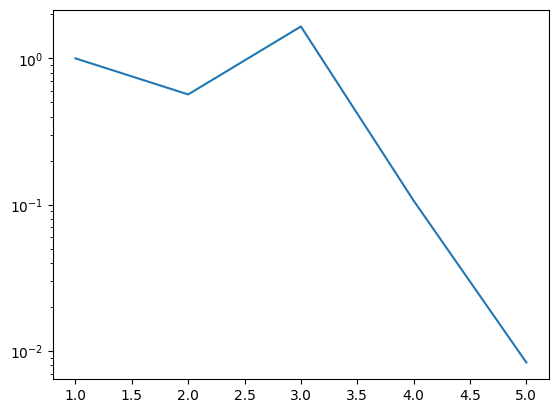

In [183]:
iters = np.arange(1, len(final_angles)+1)
plt.plot(iters, np.abs(errors))
plt.yscale('log')
plt.show()

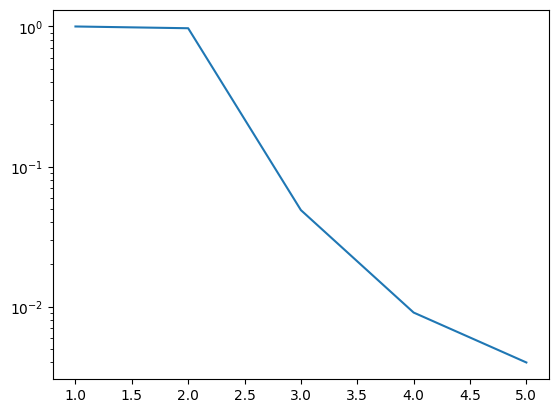

In [173]:
iters = np.arange(1, len(final_angles)+1)
plt.plot(iters, np.abs(errors))
plt.yscale('log')
plt.show()

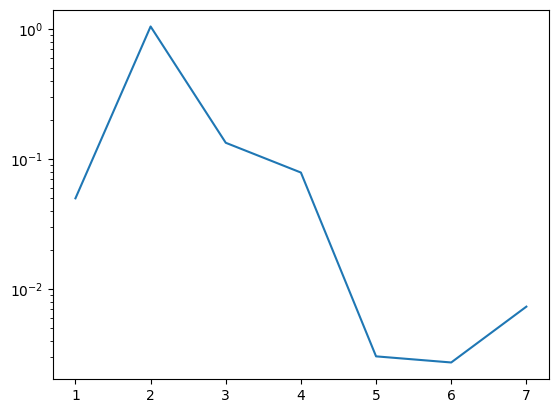

In [141]:
iters = np.arange(1, len(final_angles)+1)
plt.plot(iters, np.abs(np.array(final_angles) - 0.05))
plt.yscale('log')
plt.show()

# Big $U$

In [17]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt
from pytket.circuit import Op
from pytket.circuit import OpType
from pytket.circuit import QControlBox
from pytket.circuit import ConjugationBox
from pytket.circuit import CircBox
import numpy as np
from pytket.extensions.qiskit import tk_to_qiskit
from pytket.passes import DecomposeBoxes

In [21]:
theta_1=0.5
theta_2=0.7
theta_3=0.2
# Define the angles for the rotations
Rz_op = lambda angle: Op.create(OpType.Rz, angle)
Conz0=QControlBox(Rz_op(theta_1),n_controls=3,control_state=[0,1,2])
Conz1=QControlBox(Rz_op(theta_2),n_controls=3,control_state=[0,1,2])
Conz2=QControlBox(Rz_op(theta_3),n_controls=3,control_state=[0,1,2])

A=Circuit(4)

A.add_gate(Conz0,[2,0,1,3])
A.add_gate(Conz1,[1,0,2,3])
A.add_gate(Conz2,[0,1,2,3])

#render_circuit_jupyter(A)
C=Circuit(4)

C.CX(2, 3)
# Assuming the first three steps include another CNOT from qubit 1 to qubit 2
C.CX(1, 3)
# And one more CNOT from qubit 0 to qubit 1
C.CX(0, 3)
C.H(3)
#render_circuit_jupyter(C)
c_box = CircBox(C)
a_box= CircBox(A)
conj_box=ConjugationBox(c_box,a_box)
circ=Circuit(4)
circ.add_gate(conj_box,[0,1,2,3])

#render_circuit_jupyter(circ)
finalu=QControlBox(conj_box,n_controls=1,control_state=[0])
circ=Circuit(5)
circ.add_gate(finalu,[0,1,2,3,4])


#render_circuit_jupyter(circ)
DecomposeBoxes().apply(circ)
cU = tk_to_qiskit(circ)
cU.name = 'cU'

In [26]:
# Function to apply controlled-U operations
def apply_big_cu(qc, ctrl_qubit, target_qubits, U, power):
    U_cp = U.copy()
    U_cp.name = f"U^{2**power}"
    qc.append(U_cp.control(), [ctrl_qubit, *target_qubits])

In [37]:
def qiskit_circuit_big_U(M, angle, shots=10):

    # Prepare the quantum circuit
    qc = QuantumCircuit(5, 1)  # 2 qubits, 1 classical bit for measurement

    # Initialize the eigenstate of U (assuming |1> is an eigenstate of U)
    # qc.x(1)  # Prepare the state |1>

    for k in range(1):
        # Apply Hadamard to auxiliary qubit
        qc.h(0)
        
        # Apply controlled-U operations conditioned on previous outcomes
        for i in range(M):
            qc.append(cU, range(5))

        qc.rz(angle, 0)
        
        # Apply the inverse QFT (Hadamard for single qubit)
        qc.h(0)
        
        # Measure
        qc.measure(0, 0)

        #print(qc.draw())
        
        # Execute the circuit
        backend = Aer.get_backend('qasm_simulator')
        job = execute(qc, backend, shots=shots)
        result = job.result()
        measurement = result.get_counts()

        #print(qc.draw())

        return measurement

In [36]:
qiskit_circuit_big_U(2, 1.)

     ┌───┐┌─────┐┌─────┐┌───────┐┌───┐┌─┐
q_0: ┤ H ├┤0    ├┤0    ├┤ Rz(1) ├┤ H ├┤M├
     └───┘│     ││     │└───────┘└───┘└╥┘
q_1: ─────┤1    ├┤1    ├───────────────╫─
          │     ││     │               ║ 
q_2: ─────┤2 cU ├┤2 cU ├───────────────╫─
          │     ││     │               ║ 
q_3: ─────┤3    ├┤3    ├───────────────╫─
          │     ││     │               ║ 
q_4: ─────┤4    ├┤4    ├───────────────╫─
          └─────┘└─────┘               ║ 
c: 1/══════════════════════════════════╩═
                                       0 


{'1': 1, '0': 9}

In [43]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.quantum_info import Operator
import numpy as np

# Use Aer's unitary simulator to simulate the circuit
backend = Aer.get_backend('unitary_simulator')
job = backend.run(transpile(cU, backend))
unitary = job.result().get_unitary(cU)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(unitary)

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:", eigenvectors)



Eigenvalues: [1.        -2.10942375e-15j 1.        -3.08086889e-15j
 1.        -7.74580024e-17j 1.        -1.73472348e-16j
 1.        -1.86482774e-16j 1.        +1.11022302e-16j
 1.        -3.05311332e-16j 0.70710678-7.07106781e-01j
 0.70710678+7.07106781e-01j 0.4539905 +8.91006524e-01j
 0.4539905 -8.91006524e-01j 0.95105652-3.09016994e-01j
 0.95105652+3.09016994e-01j 1.        -9.36750677e-17j
 1.        -1.85615412e-16j 1.        -3.06937635e-16j
 1.        -1.60353501e-16j 1.        -3.21964677e-15j
 1.        -2.08166817e-15j 1.        -5.55111512e-17j
 1.        -2.64718802e-15j 1.        -2.08513762e-15j
 1.        -9.02056208e-17j 1.        -2.77555756e-15j
 1.        -2.49800181e-16j 1.        -3.01841885e-15j
 1.        -1.84921523e-15j 1.        -1.38777878e-17j
 1.        -2.33146835e-15j 1.        -1.94289029e-16j
 1.        -1.11022302e-16j 1.        -5.55111512e-17j]
Eigenvectors: [[ 7.32130177e-01+0.00000000e+00j  6.93163548e-01-5.89489014e-02j
   8.03832179e-03+5.289728

In [44]:
def vec_to_dirac(vector, threshold=1e-6):
    """
    Converts a vector representing a quantum state into Dirac notation.

    Parameters:
    - vector: numpy array, the vector to be converted.
    - threshold: float, the minimum absolute value for coefficients to be included.

    Returns:
    - A string representing the vector in Dirac notation.
    """
    # Determine the number of qubits from the vector length
    num_qubits = int(np.log2(len(vector)))
    dirac_notation = ""
    
    for i, amplitude in enumerate(vector):
        # Skip amplitudes below the threshold
        if np.abs(amplitude) > threshold:
            # Convert the index to binary and format it as a basis state
            basis_state = format(i, f'0{num_qubits}b')
            # Add the term to the Dirac notation string
            amplitude_str = f"{amplitude:.2f}" if np.imag(amplitude) == 0 else f"({amplitude:.2f})"
            dirac_notation += f"{amplitude_str}|{basis_state}> + "
    
    # Remove the last ' + ' if the string is not empty
    if dirac_notation:
        dirac_notation = dirac_notation[:-3]
    
    return dirac_notation


In [48]:
for eigenvector in eigenvectors:
    print(vec_to_dirac(eigenvector, threshold=1e-2))

0.73+0.00j|00000> + (0.69-0.06j)|00001>
1.00+0.00j|00010> + (-0.06-0.01j)|00011> + (-0.13+0.01j)|00100> + (-0.01-0.01j)|00101> + (0.01+0.01j)|00110>
(-0.01+0.01j)|10001> + (0.02-0.01j)|10010> + (0.02-0.05j)|10011> + (-0.15-0.21j)|10100> + (-0.14+0.12j)|10101> + (0.00-0.09j)|10110> + (-0.52+0.12j)|10111> + (-0.06+0.02j)|11000> + (-0.50-0.10j)|11001> + (0.33-0.23j)|11010> + (-0.02-0.06j)|11011> + (0.16-0.27j)|11100> + (0.01+0.01j)|11110> + (0.01+0.01j)|11111>
0.71+0.00j|00011> + 0.87+0.00j|00100> + (0.11+0.01j)|00101> + (0.04-0.16j)|00110> + (0.03-0.01j)|01101>
(-0.00+0.03j)|10001> + (0.03-0.05j)|10010> + 0.60+0.00j|10100> + (0.40+0.28j)|10101> + (0.01+0.08j)|10110> + (-0.39-0.15j)|10111> + (-0.01+0.13j)|11000> + (-0.28-0.06j)|11001> + (0.10-0.05j)|11010> + (-0.05-0.05j)|11011> + (0.01+0.13j)|11100> + (-0.01-0.04j)|11101> + (-0.05+0.02j)|11110> + (0.03-0.01j)|11111>
(-0.47+0.01j)|00101> + 0.76+0.00j|00110> + (0.13-0.17j)|01101> + (-0.02+0.01j)|01110>
(0.71-0.00j)|00111> + (-0.71+0.00j)|0

In [52]:
phases = np.angle(eigenvalues)
phases

array([-2.10942375e-15, -3.08086889e-15, -7.74580024e-17, -1.73472348e-16,
       -1.86482774e-16,  1.11022302e-16, -3.05311332e-16, -7.85398163e-01,
        7.85398163e-01,  1.09955743e+00, -1.09955743e+00, -3.14159265e-01,
        3.14159265e-01, -9.36750677e-17, -1.85615412e-16, -3.06937635e-16,
       -1.60353501e-16, -3.21964677e-15, -2.08166817e-15, -5.55111512e-17,
       -2.64718802e-15, -2.08513762e-15, -9.02056208e-17, -2.77555756e-15,
       -2.49800181e-16, -3.01841885e-15, -1.84921523e-15, -1.38777878e-17,
       -2.33146835e-15, -1.94289029e-16, -1.11022302e-16, -5.55111512e-17])

In [53]:


# Threshold for rounding small angles to zero
threshold = 1e-6

# Round small angles to zero
phases_rounded = np.where(np.abs(phases) < threshold, 0, phases)

# Compute the eigenvalues of the Hamiltonian with rounded phases
hamiltonian_eigenvalues_rounded = phases_rounded

hamiltonian_eigenvalues_rounded


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.78539816,  0.78539816,  1.09955743,
       -1.09955743, -0.31415927,  0.31415927,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])